In [ ]:
import pickle
import zipfile
from google.colab import drive
drive.mount('/content/drive')

# update path to import from Drive
import sys
sys.path.append('content/drive/MyDrive')

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim as optim
import time
from time import sleep
from tqdm import tqdm

with zipfile.ZipFile('/content/drive/MyDrive/FPN/FFPN-Lodopab-TrainingData-IndividualNoise.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

sys.path.append('content/drive/MyDrive/FPN')
sys.path.insert(0,'/content/drive/My Drive/FPN')

Mounted at /content/drive


In [ ]:
from FPNLBA import FPN
device = 'cuda'

In [ ]:
# load train data
# folder_path = './dataset/'
folder_path = './'

data_path = folder_path + 'FFPN-Lodopab-TrainingData-0.015IndividualNoise.pkl'

state = torch.load(data_path)

A = state['A'].to(device)
data_obs_train = state['data_obs_train']
data_obs_test = state['data_obs_test']
u_train       = state['u_true_train']
u_test       = state['u_true_test']

n_samples       = data_obs_train.shape[0]
n_samples_test  = data_obs_test.shape[0]

print('u_train.shape =', u_train.shape)
print('u_test.shape = ', u_test.shape)
print('data_obs_train.shape = ', data_obs_train.shape)
print('data_obs_test.shape = ', data_obs_test.shape)

u_train.shape = torch.Size([20000, 1, 128, 128])
u_test.shape =  torch.Size([2000, 1, 128, 128])
data_obs_train.shape =  torch.Size([20000, 1, 30, 183])
data_obs_test.shape =  torch.Size([2000, 1, 30, 183])


In [ ]:
# Create training datasets

batch_size = 50

data_train      = TensorDataset(u_train[0:n_samples,:,:,:], data_obs_train[0:n_samples,:,:,:])
data_loader     = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)

n_batches = int(len(data_loader.dataset)/batch_size)

# Info about the dataset
print()
print(f'u_train.min(): {u_train.min()}')
print(f'u_train.max(): {u_train.max()}')
print("data_obs_train.shape = ", data_obs_train.shape)
print('n_batches = ', n_batches)
#print()*7410

print("A size = ", A.size())
S = torch.diag(torch.count_nonzero(A, dim=0) ** -1.0).float().to(device)
print(S)
print('S size = ', S.size())


u_train.min(): 0.0
u_train.max(): 1.0
data_obs_train.shape =  torch.Size([20000, 1, 30, 183])
n_batches =  400
A size =  torch.Size([5490, 16384])
tensor([[0.0147, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0143, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0154,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0149, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0149, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0147]],
       device='cuda:0')
S size =  torch.Size([16384, 16384])


In [ ]:
latent_variable = torch.Tensor
image           = torch.Tensor
classification  = torch.Tensor
measurement     = torch.Tensor

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# Create neural network model and initialize it
# ----------------------------------------------------------------------------------------------------------------------
class Regularizer_Net(nn.Module):
    def __init__(self, D, M, res_net_contraction=0.99):
        super().__init__()
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.gamma = res_net_contraction
        self.num_channels = 44     
        self.D = D 
        self.convs = nn.ModuleList([nn.Conv2d(1, self.num_channels, 
                                              kernel_size=5, stride=1, 
                                              padding=(2,2)),
                                    nn.Conv2d(self.num_channels, 
                                              self.num_channels, kernel_size=5, 
                                              stride=1, padding=(2,2)),
                                    nn.Conv2d(self.num_channels, 
                                              self.num_channels, kernel_size=5, 
                                              stride=1, padding=(2,2)),
                                    nn.Conv2d(self.num_channels, 1, 
                                              kernel_size=5, stride=1, 
                                              padding=(2,2))])
        self.M = M
        self.Mt = M.t()         

    def name(self) -> str:
        return "Regularizer_Net"

    def device(self):
        return next(self.parameters()).data.device

    def _T(self, u, d):
        batch_size = u.shape[0]

        # Learned Gradient
        for idx, conv in enumerate(self.convs):
            u_ref = u if idx + 1 < len(self.convs) else u[:,0,:,:].view(batch_size,1,128,128)
            u = u_ref + self.leaky_relu(conv(u))
        u = torch.clamp(u, min=0, max=1.0e1)

        # Constraints Projection
        u_vec = u.view(batch_size, -1).to(self.device())
        u_vec = u_vec.permute(1,0).to(self.device())   
        d = d.view(batch_size,-1).to(self.device())
        d = d.permute(1,0)
        res = torch.matmul(self.Mt, self.M.matmul(u_vec) - d)
        res = 1.99 * torch.matmul(self.D.to(self.device()), res)
        res = res.permute(1,0)
        res = res.view(batch_size, 1, 128, 128).to(self.device())
        return u - res

    def normalize_lip_const(self, u, d):
        ''' Scale convolutions in R to make it gamma Lipschitz

            It should hold that |R(u,v) - R(w,v)| <= gamma * |u-w| for all u
            and w. If this doesn't hold, then we must rescale the convolution.
            Consider R = I + Conv. To rescale, ideally we multiply R by

                norm_fact = gamma * |u-w| / |R(u,v) - R(w,v)|,
            
            averaged over a batch of samples, i.e. R <-- norm_fact * R. The 
            issue is that ResNets include an identity operation, which we don't 
            wish to rescale. So, instead we use
                
                R <-- I + norm_fact * Conv,
            
            which is accurate up to an identity term scaled by (norm_fact - 1).
            If we do this often enough, then norm_fact ~ 1.0 and the identity 
            term is negligible.

            Note: BatchNorm and ReLUs are nonexpansive when...???
        '''
        noise_u = torch.randn(u.size(), device=self.device()) 
        w = u.clone() + noise_u
        w = w.to(self.device())
        Twd = self._T(w, d)
        Tud = self._T(u, d)
        T_diff_norm = torch.mean(torch.norm(Twd - Tud, dim=1))
        u_diff_norm = torch.mean(torch.norm(w - u, dim=1))
        R_is_gamma_lip = T_diff_norm <= self.gamma * u_diff_norm
        if not R_is_gamma_lip:
            normalize_factor = (self.gamma * u_diff_norm / T_diff_norm) ** (1.0 / len(self.convs))
            for i in range(len(self.convs)):
                self.convs[i].weight.data *= normalize_factor
                self.convs[i].bias.data *= normalize_factor

    def forward(self, d, eps=1.0e-3, max_depth=100, 
                depth_warning=False):
        ''' FPN forward prop

            With gradients detached, find fixed point. During forward iteration,
            u is updated via R(u,Q(d)) and Lipschitz constant estimates are
            refined. Gradient are attached performing one final step.
        '''         
        with torch.no_grad():
            self.depth = 0.0
            u = torch.zeros((d.size()[0], 1, 128, 128), 
                            device=self.device())
            u_prev = np.Inf*torch.ones(u.shape, device=self.device())            
            all_samp_conv = False
            while not all_samp_conv and self.depth < max_depth:
                u_prev = u.clone()   
                u = self._T(u, d)
                res_norm = torch.max(torch.norm(u - u_prev, dim=1)) 
                self.depth += 1.0
                all_samp_conv = res_norm <= eps
            
            if self.training:
                self.normalize_lip_const(u, d)

        if self.depth >= max_depth and depth_warning:
            print("\nWarning: Max Depth Reached - Break Forward Loop\n")

        return self._T(u, d)                

In [ ]:
#-------------------------------------------------------------------------------
# Set up training parameters
#-------------------------------------------------------------------------------

Phi = Regularizer_Net(S, A)
Phi = Phi.to(device)

pytorch_total_params = sum(p.numel() for p in Phi.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {pytorch_total_params}')



Number of trainable parameters: 99133


In [ ]:
max_epochs    = 10
learning_rate = 1.0e-5
max_depth     = 150
eps           = 1.0e-3

criterion = torch.nn.MSELoss()  
optimizer = optim.Adam(Phi.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=1.0)

fmt        = '[{:2d}/{:2d}]: train_loss = {:7.3e} | ' 
fmt       += 'depth = {:5.1f} | lr = {:5.1e} | time = {:4.1f} sec'


load_weights = True
if load_weights:
    # FOR RELOADING
    state = torch.load('./drive/MyDrive/FPN/Feasible_FPN_Lodopab_weights.pth') 
    Phi.load_state_dict(state['Phi_state_dict'])
    print('Loaded Phi from file.')

Loaded Phi from file.


In [ ]:
#-------------------------------------------------------------------------------
# Execute Training
#-------------------------------------------------------------------------------
best_loss = 1.0e10 

for epoch in range(max_epochs): 
  sleep(0.5)  # slows progress bar so it won't print on multiple lines
  tot = len(data_loader)
  loss_ave = 0.0
  start_time_epoch = time.time() 
  with tqdm(total=tot, unit=" batch", leave=False, ascii=True) as tepoch:
      
    for idx, (u_batch, d) in enumerate(data_loader): 
      u_batch    = u_batch.to(device) 
      batch_size = u_batch.shape[0]
      d = d.view(batch_size, -1).to(device)

      train_batch_size = d.shape[0] 
      Phi.train()
      optimizer.zero_grad()
      u = Phi(d, max_depth=max_depth, eps=eps) 
      loss_val = criterion(u, u_batch)
      train_loss = loss_val.detach().cpu().numpy()
      loss_ave += train_loss * train_batch_size
      loss_val.backward()
      optimizer.step()


      tepoch.update(1)
      tepoch.set_postfix(train_loss="{:5.2e}".format(train_loss),
                            depth="{:5.1f}".format(Phi.depth))
    
    if epoch%1 == 0:
        # compute test image 
        Phi.eval()
        testing_image = data_obs_test[0,0,:,:].view(1,1,-1)
        u_test_approx = Phi(testing_image, max_depth=max_depth, eps=eps)

        plt.figure()
        plt.subplot(2,2,1)
        plt.imshow(u_batch[0,0,:,:].cpu(), vmin=0, vmax=1)
        plt.title('u true train')
        plt.subplot(2,2,2)
        plt.imshow(u[0,0,:,:].detach().cpu(), vmin=0, vmax=1)
        plt.title('u approx train')
        plt.subplot(2,2,3)
        plt.imshow(u_test[0,0,:,:].cpu(), vmin=0, vmax=1)
        plt.title('u true test')
        plt.subplot(2,2,4)
        plt.imshow(u_test_approx[0,0,:,:].detach().cpu(), vmin=0, vmax=1)
        plt.title('u approx test')
        plt.show() 

        Phi.train() 

    # ---------------------------------------------------------------------
    # Save weights
    # ---------------------------------------------------------------------
    if loss_ave < best_loss:
        best_loss = loss_ave
        state = {
            'Phi_state_dict': Phi.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler
        }
        file_name = './drive/MyDrive/FPN/Feasible_FPN_Lodopab_weights.pth'
        torch.save(state, file_name)
        print('\nModel weights saved to ' + file_name)        
    
  loss_ave = loss_ave/len(data_loader.dataset)
  end_time_epoch = time.time()
  time_epoch = end_time_epoch - start_time_epoch
  lr_scheduler.step()
  print(fmt.format(epoch+1, max_epochs, loss_ave, Phi.depth, 
                   optimizer.param_groups[0]['lr'],
                   time_epoch))

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

n_samples = u_test.shape[0]

data_test     = TensorDataset(u_test, data_obs_test)
test_data_loader     = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=True)


def compute_avg_SSIM_PSNR(u_true, u_gen, n_mesh, data_range):
    # assumes images are size n_samples x n_features**2 and are detached
    n_samples = u_true.shape[0]
    u_true = u_true.reshape(n_samples, n_mesh, n_mesh).cpu().numpy()
    u_gen  = u_gen.reshape(n_samples, n_mesh, n_mesh).cpu().numpy()
    ssim_val = 0
    psnr_val = 0
    for j in range(n_samples):
        ssim_val = ssim_val + ssim(u_true[j,:,:], u_gen[j,:,:], data_range=data_range)
        psnr_val = psnr_val + psnr(u_true[j,:,:], u_gen[j,:,:], data_range=data_range)
    return ssim_val/n_samples, psnr_val/n_samples

In [ ]:

test_loss_ave = 0
test_PSNR_ave = 0
test_SSIM_ave = 0
with torch.no_grad():
    for idx, (u_batch, d) in enumerate(test_data_loader): 

        u_batch    = u_batch.to(device) 
        batch_size = u_batch.shape[0]
        temp       = u_batch.view(batch_size, -1)
        temp       = temp.permute(1,0)        
        test_batch_size = d.shape[0] # re-define if batch size changes
        Phi.eval()
        u = Phi(d, max_depth=max_depth, eps=eps) # add snippet for hiding
        output = criterion(u, u_batch)
        test_loss = output.detach().cpu().numpy()
        test_SSIM, test_PSNR = compute_avg_SSIM_PSNR(u_batch, u, 128, 1)
        test_PSNR_ave += test_PSNR * test_batch_size
        test_loss_ave += test_loss * test_batch_size
        test_SSIM_ave += test_SSIM * test_batch_size

        print('test_PSNR = {:7.3e}'.format(test_PSNR))
        print('test_SSIM = {:7.3e}'.format(test_SSIM))
        print('test_loss = {:7.3e}'.format(test_loss))
        if idx%1 == 0:
            # compute test image 
            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(u_batch[0,0,:,:].cpu(), vmin=0, vmax=1)
            plt.title('u true')
            plt.subplot(1,2,2)
            plt.imshow(u[0,0,:,:].detach().cpu(), vmin=0, vmax=1)
            plt.title('u approx')
            plt.show()  

In [ ]:
print('\n\nSUMMARY')
print('test_loss_ave =  {:7.3e}'.format(test_loss_ave / 2000))
print('test_PSNR_ave =  {:7.3e}'.format(test_PSNR_ave / 2000))
print('test_SSIM_ave =  {:7.3e}'.format(test_SSIM_ave / 2000))



SUMMARY
test_loss_ave =  9.585e-04
test_PSNR_ave =  3.046e+01
test_SSIM_ave =  8.319e-01


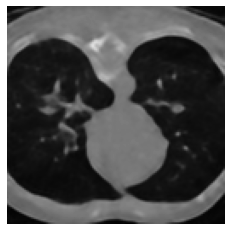

SSIM:  (0.8319270686541259, 28.98200842392084)


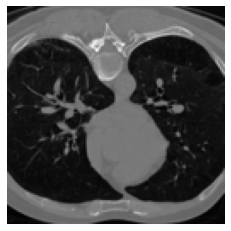

In [ ]:
ind_val = 1000

u = Phi(data_obs_test[ind_val,:,:,:]).view(128,128)
u_true = u_test[ind_val,0,:,:]
def string_ind(index):
    if index < 10:
        return '000' + str(index)
    elif index < 100:
        return '00' + str(index)
    elif index < 1000:
        return '0' + str(index)
    else:
        return str(index)

cmap = 'gray'
fig = plt.figure()
plt.imshow(np.rot90(u.detach().cpu().numpy()),cmap=cmap, vmin=0, vmax=1)
plt.axis('off')


save_loc = './Learned_Feasibility_Lodopab_FFPN_ind_' + string_ind(ind_val) + '.pdf'
plt.savefig(save_loc,bbox_inches='tight')
plt.show()

print("SSIM: ", compute_avg_SSIM_PSNR(u_true.view(1,128,128), u.view(1,128,128).detach(), 128, 1))

#------------------------------------------------------------
# TRUE
#------------------------------------------------------------

cmap = 'gray'
fig = plt.figure()
plt.imshow(np.rot90(u_true.detach().cpu().numpy()),cmap=cmap, vmin=0, vmax=1)
plt.axis('off')


save_loc = './Learned_Feasibility_Lodopab_GT_ind_' + string_ind(ind_val) + '.pdf'
plt.savefig(save_loc,bbox_inches='tight')
plt.show()
